*Probabilistic Inference using HMC in Python.*  
------------------------------------------------------------------
*Samantha Deokinanan*  
*CUNY MSDS DATA 621 Blog # 5*  
*November 21st, 2020*    

---

Hamiltonian Monte Carlo (HMC) method is an Markov chain Monte Carlo (MCMC) method that adopts physical system dynamics rather than a probability distribution to propose future states in the Markov chain. This allows the Markov chain to explore the target distribution much more efficiently, resulting in faster convergence (Betancourt, 2017). It is the standard method for probabilistic inference using MCMC in many other fields as well. 

In this tutorial, to avoid using proprietary data, a common example is presented with the use of the data from NASA exoplanet archive. There will be a demonstration of how to fit a radial velocity model, in this case, a Keplerian orbit, to the public radial velocity observations of 51 Peg. To build the model, the data needs to be fitted using a Keplerian model where the radial velocity is given by:

<center> $RV(t) = RV_0 + RV_\mathrm{trend}\,t + K\,\left[\cos(\omega+f(t))+e\,\cos(\omega)\right]$ </center>

where $RV_0$ is the mean radial velocity, $RV_{trend}$ is the slope of the RV trend, K is the semi-amplitude, ω is the argument of periastron, and f(t) is the true anomaly. The computation of f(t) requires solving Kepler's equation:

<center> $M = E − e sin(E)$ </center>

for the eccentric anomaly $E$ given some mean anomaly $M$ and eccentricity $e$ (Lovis, *et al*, 2010).

Let's load the data and plot the radial velocities:

In [1]:
# Main modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano.tensor as tt
import pymc3 as pm
import exoplanet as xo

# Minor modules
import requests

# Load dataset
url = "https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0113/0113357/data/UID_0113357_RVC_001.tbl"
r = requests.get(url)
if r.status_code != requests.codes.ok:
    r.raise_for_status()
data = np.array(
    [l.split()
     for l in r.text.splitlines()
     if not l.startswith("\\") and not l.startswith("|")],
    dtype=float,)
t, rv, rv_err = data.T
t -= np.mean(t)

In [2]:
data[1:10]

array([[-374.41829153,  -45.8       ,    4.8       ],
       [-374.30241153,  -60.8       ,    4.6       ],
       [-374.28667053,  -53.3       ,    5.        ],
       [-374.14792053,  -60.9       ,    5.5       ],
       [-374.13434453,  -57.3       ,    7.        ],
       [-373.49125453,  -24.2       ,    5.        ],
       [-373.47573353,  -30.5       ,    4.6       ],
       [-373.45966853,  -26.        ,    4.9       ],
       [-373.38604553,  -19.2       ,    4.2       ]])

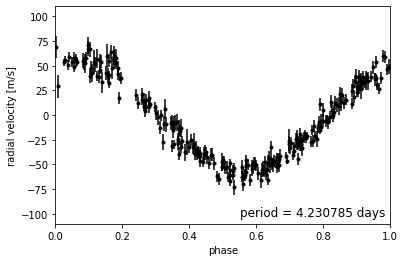

In [3]:
# Plot the observations 
lit_period = 4.230785
plt.errorbar((t % lit_period) / lit_period, 
             rv, 
             yerr = rv_err, 
             fmt = ".k", 
             capsize = 0)
plt.xlim(0, 1)
plt.ylim(-110, 110)
plt.annotate("period = {0:.6f} days".format(lit_period),
             xy = (1, 0),
             xycoords = "axes fraction",
             xytext = (-5, 5),
             textcoords = "offset points",
             ha = "right",
             va = "bottom",
             fontsize = 12)
plt.ylabel("radial velocity [m/s]")
_ = plt.xlabel("phase")

Now things get interesting as the model is built. Start by initializing the parameters with test values. It is inefficient to optimize with random restarts within the prior if there are constrained parameters (e.g. in this case, period). Moreover, there is already a good initial guess for the values of these parameters anyway.

Also, by having Deterministic distributions for some of the features, tracking the values as the chain progresses is easier even if they’re not parameters. For parameters that specify angles like $\omega$, it can be inefficient to sample in the angle directly because the value wraps around at 2$\pi$. Instead, sampling in done using the unit vector specified by the angle or as a parameter in a unit disk, when combined with eccentricity. Therefore, 

<center> $h = \sqrt(e) * sin(\omega)$ </center>
<center> $k = \sqrt(e) * cos(\omega)$ </center>

In [4]:
with pm.Model() as model:
    # Parameters
    logK = pm.Uniform(
        "logK",
        lower = 0,
        upper = np.log(200),
        testval = np.log(0.5 * (np.max(rv) - np.min(rv))),
    )
    logP = pm.Uniform(
        "logP", 
        lower = 0, 
        upper = np.log(10), 
        testval = np.log(lit_period)
    )
    phi = pm.Uniform(
        "phi", 
        lower = 0,
        upper = 2 * np.pi, 
        testval = 0.1)

    # Parameterize the eccentricity
    hk = xo.UnitDisk("hk", testval = np.array([0.01, 0.01]))
    e = pm.Deterministic("e", hk[0] ** 2 + hk[1] ** 2)
    w = pm.Deterministic("w", tt.arctan2(hk[1], hk[0]))

    rv0 = pm.Normal("rv0", mu = 0.0, sd = 10.0, testval = 0.0)
    rvtrend = pm.Normal("rvtrend", mu = 0.0, sd = 10.0, testval = 0.0)

    # Deterministic transformations
    n = 2 * np.pi * tt.exp(-logP)
    P = pm.Deterministic("P", tt.exp(logP))
    K = pm.Deterministic("K", tt.exp(logK))
    cosw = tt.cos(w)
    sinw = tt.sin(w)
    t0 = (phi + w) / n

    # The RV model
    bkg = pm.Deterministic("bkg", rv0 + rvtrend * t / 365.25)
    M = n * t - (phi + w)

    # Add a custom Kepler solver
    f = xo.orbits.get_true_anomaly(M, e + tt.zeros_like(M))
    rvmodel = pm.Deterministic(
        "rvmodel", bkg + K * (cosw * (tt.cos(f) + e) - sinw * tt.sin(f))
    )

    # Condition on the observations
    pm.Normal("obs", mu = rvmodel, sd = rv_err, observed = rv)

    # Compute the phased RV signal
    phase = np.linspace(0, 1, 500)
    M_pred = 2 * np.pi * phase - (phi + w)
    f_pred = xo.orbits.get_true_anomaly(M_pred, e + tt.zeros_like(M_pred))
    rvphase = pm.Deterministic(
        "rvphase", K * (cosw * (tt.cos(f_pred) + e) - sinw * tt.sin(f_pred)))

Next, optimize the parameters to find the maximum a posteriori parameters (MAP) and then start the sampler. This is useful because MCMC is not designed to find the maximum of the posterior. It’s only meant to sample the shape of the posterior. 

In [5]:
with model:
    map_params = xo.optimize()

optimizing logp for variables: [rvtrend, rv0, hk, phi, logP, logK]


message: Optimization terminated successfully.
logp: -1962.1917788394746 -> -850.9360446619803


Now let’s sample the posterior starting from the MAP estimate. Note, the model is being tuned automatically using No-U-Turn Sampler method, which uses a recursive algorithm to build a set of likely candidate points that spans the target distribution, and only stopping when when it turns back on itself.

In [6]:
with model:
    trace = pm.sample(
        draws = 2000,
        tune = 1000,
        start = map_params,
        chains = 2,
        cores = 2,
        target_accept = 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rvtrend, rv0, hk, phi, logP, logK]
Sampling 2 chains, 0 divergences: 100%|█| 6000/6000 [01:00<00:00, 99.21draws/s]


From the above, the run was a success with no divergences. Using the samples, let's plot the distribution of predicted models from the posterior predictive density. In the top plot, it is the RV observations as a function of time. The raw observations is the black error bars and the RV trend model is plotted in blue. The second plot below it, is a plot of the “folded” curve which is composed of 30 lines that are sampled from the posterior over trends that are consistent with the data for the RV curve of one orbit.

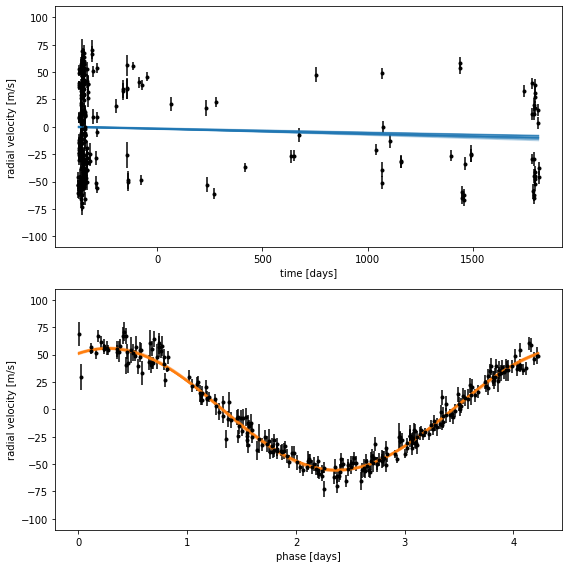

In [7]:
fig, axes = plt.subplots(2, 1, figsize = (8, 8))

period = map_params["P"]

ax = axes[0]
ax.errorbar(t, rv, yerr=rv_err, fmt=".k")
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("time [days]")

ax = axes[1]
ax.errorbar(t % period, rv - map_params["bkg"], yerr = rv_err, fmt = ".k")
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("phase [days]")

# Sample lines from trace and plot
for i in np.random.randint(len(trace) * trace.nchains, size = 30):
    axes[0].plot(t, trace["bkg"][i], color="C0", lw = 1, alpha = 0.3)
    axes[1].plot(phase * period, trace["rvphase"][i], color = "C1", lw = 1, alpha = 0.3)

axes[0].set_ylim(-110, 110)
axes[1].set_ylim(-110, 110)

plt.tight_layout()

In conclusion, by using HMC, there was success in simulating and fitting radial velocity observations to the exoplanet data.

---
Works Cited:

* Betancourt, Michael. "A conceptual introduction to Hamiltonian Monte Carlo." arXiv preprint arXiv:1701.02434 (2017).

* Butler, R. Paul, et al. "Catalog of nearby exoplanets." The Astrophysical Journal 646.1 (2006): 505.

* exoplanet:exoplanet, Daniel Foreman-Mackey; Rodrigo Luger; Ian Czekala; Eric Agol; Adrian Price-Whelan; Emily Gilbert; Timothy D. Brandt; Tom Barclay and Luke Bouma, exoplanet-dev/exoplanet v0.4.1, Nov, 2020, https://doi.org/10.5281/zenodo.1998447

* Lovis, Christophe, and Debra Fischer. "Radial velocity techniques for exoplanets." Exoplanets (2010): 27-53.

* Salvatier J., Wiecki T.V., Fonnesbeck C. (2016) Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55 DOI: 10.7717/peerj-cs.55.
